fase de clasificacion supervisada: preparar cuadernillos con los experimentos, explicar modelos utilizados (reg log, random forest ... cnn), comparar rendimiendo y buscar formas para mejorar

Una vez obtenido un dataset con suficientes noticias de cada categoria objetivo, procedimos a realizar los primeros entrenamientos de distintos modelos de clasificacion supervisada, contemplando tambien una fase de preprocesamiento de la entrada para mejorar en algunos aspectos y simplificar otros...

# Preprocesamiento

## Titulo y cuerpo de la noticia

Como se comento en pasos anteriores, el titulo de una noticia es de gran importancia ya que concentra una gran cantidad de informacion, por lo que es una buena idea incluirlo dentro de los datos con los que se entrenaran nuestros modelos. El dataset contiene una columna 'content' en el que se encuentra el titulo de la noticia mas el cuerpo 

...

In [3]:
import pandas as pd
from pandasql import sqldf
from os.path import join
from os import listdir

In [4]:
folder = './datasets/'

for file in reversed(sorted(listdir(folder))):
    if 'balanced' in file:
        print(file)

ds_semibalanced_1658_rs5150.csv
ds_semibalanced_1500_rs5150.csv
ds_balanced_1043_rs5150.csv


In [5]:
MAX_LEN = 1600
RANDOM_STATE = 8008
folder = './datasets'
df = pd.read_csv(join(folder, 'ds_balanced_1043_rs5150.csv'))
#df = pd.read_csv('dataset_paso_3.csv')
pd.set_option('display.max_colwidth', 200)
df[['title', 'content']].head()

,title,content
0,Disneyland abre sus puertas como centro vacunatorio masivo contra el coronavirus,"Disneyland abre sus puertas como centro vacunatorio masivo contra el coronavirus. El parque de atracciones Disneyland en Anaheim, California, ha estado cerrado desde mediado de marzo por el alza d..."
1,México autoriza vacuna de Pfizer y es el primer país de Latinoamérica en aprobarla: Inoculación comenzaría este mes,México autoriza vacuna de Pfizer y es el primer país de Latinoamérica en aprobarla: Inoculación comenzaría este mes. La Comisión Federal para la Protección contra Riesgos Sanitarios (Cofepris) del...
2,El mega operativo de seguridad en Washington por la investidura de Biden: Será la ceremonia con más militares de la historia,"El mega operativo de seguridad en Washington por la investidura de Biden: Será la ceremonia con más militares de la historia. En Washington, un amplio perímetro que ocupa todo el centro, incluid..."
3,"""Swing states"" o estados bisagras: los terrenos claves donde se definirá la presidencial de EEUU","""Swing states"" o estados bisagras: los terrenos claves donde se definirá la presidencial de EEUU. Estados Unidos está ad portas de elegir a quien dirigirá los destinos del país por los próximos cu..."
4,"Merkel defiende nuevas restricciones y advierte sobre ""mentiras"" en lucha contra el covid","Merkel defiende nuevas restricciones y advierte sobre ""mentiras"" en lucha contra el covid. La Canciller alemana Angela Merkel defendió este jueves las nuevas medidas restrictivas anunciadas por ..."


In [8]:
df.groupby(['category']).size().sort_values()

category
1-Mundo                        1043
10-Salud                       1043
2-Economía                     1043
3-Política_y_Conflictos        1043
4-Ciencias_y_Tecnología        1043
5-Catástrofes_y_Accidentes     1043
6-Cultura_y_Artes              1043
7-Deporte                      1043
8-Ecología_y_Planeta           1043
9-Crimen_delitos_y_Justicia    1043
dtype: int64

# balancear el dataset alan tigua?
## Exportar dataset balanceado para el siguiente paso

In [9]:
df.groupby(['category']).size().sort_values()

category
1-Mundo                        1043
10-Salud                       1043
2-Economía                     1043
3-Política_y_Conflictos        1043
4-Ciencias_y_Tecnología        1043
5-Catástrofes_y_Accidentes     1043
6-Cultura_y_Artes              1043
7-Deporte                      1043
8-Ecología_y_Planeta           1043
9-Crimen_delitos_y_Justicia    1043
dtype: int64

## Truncar contenido


habria que probar si esto mejora los pasos anteriores (lda) xd

In [10]:
lol = df.content.map(len).idxmax()
print("len: ", len(df.iloc[lol].content), "\n", df.iloc[lol].content[:2000], "...") # ?????

len:  18447 
 Liberen a Lolita. Lyla Snover (86) aún recuerda los gritos que interrumpieron la tranquilidad de ese 8 de agosto de 1970 en Penn Cove, una bahía en la zona de Puget Sound, al norte de Seattle. “Eran llantos de agonía, de tristeza; se sentían de la misma manera que si raptaran alguno de tus hijos, lo pusieran en un corral y no supieras dónde está”, contó la anciana en un acto realizado en 2019 para marcar el día en que cazadores llegaron al lugar para atrapar orcas. Los captores, que se desplazaban en botes y aviones, lanzaron explosivos al agua para desorientar a los cetáceos y forzarlos a dirigirse hacia Penn Cove, donde fueron acorralados y los ejemplares más jóvenes terminaron separados de sus madres. Ellas fueron liberadas, pero se quedaron en el lugar emitiendo sonidos muy parecidos a llantos humanos. John Carpenter, un vecino de Snover que tenía cinco años, vio cómo transportaban una orca cubierta con toallas húmedas y en su memoria aún están la mirada del animal y 

## Cuanto truncar??

In [6]:
new_df = df
new_df['content'] = new_df.content.str.slice(0, MAX_LEN)

In [12]:
print('min len: ', new_df.content.map(len).min())
print('max len: ', new_df.content.map(len).max())

min len:  147
max len:  1600


## Bag of words + tf-idf

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

## NLTK

In [14]:
from nltk.corpus import stopwords
from nltk.tokenize.casual import casual_tokenize
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import partial

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib notebook
from functools import partial
import numpy as np

from string import punctuation
import re
from tqdm.auto import tqdm
import string
import spacy

In [12]:
#nltk.download('stopwords')
#nltk.download('punkt')

In [15]:
#stopwords
spanish_stopwords = stopwords.words('spanish')

#stemmer
stemmer = SnowballStemmer('spanish')

#puntuacion
non_words = list(punctuation)
#incluir puntuacion del español
non_words.extend(['¿', '¡'])
#numeros
non_words.extend(map(str,range(10)))

In [16]:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def text_cleaner(text, stem=False):
    # puntuacion
    text = ''.join([c for c in text if c not in non_words])
    # caracteres repetidos, skippeable
    text = re.sub(r'(.)\1+', r'\1\1', text)
    # tokenize
    tokens = casual_tokenize(text, preserve_case=False)
    # quitar stopwords
    filtered_sentence = [w for w in tokens if not w in spanish_stopwords]
    # stemming
    if stem:
        filtered_sentence = stem_tokens(filtered_sentence, stemmer)
    
    return " ".join(filtered_sentence)

In [17]:
train_size = 0.70

In [18]:
train_idxs = new_df.groupby('category').sample(frac=train_size, random_state=RANDOM_STATE).index
train_df = new_df.iloc[train_idxs]
q="""SELECT category, count(*) FROM train_df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,9-Crimen_delitos_y_Justicia,730
1,8-Ecología_y_Planeta,730
2,7-Deporte,730
3,6-Cultura_y_Artes,730
4,5-Catástrofes_y_Accidentes,730
5,4-Ciencias_y_Tecnología,730
6,3-Política_y_Conflictos,730
7,2-Economía,730
8,10-Salud,730
9,1-Mundo,730


In [19]:
test_idxs = pd.concat([new_df, train_df]).drop_duplicates(keep=False).index
test_df = new_df.iloc[test_idxs]
q="""SELECT category, count(*) FROM test_df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,9-Crimen_delitos_y_Justicia,313
1,8-Ecología_y_Planeta,313
2,7-Deporte,313
3,6-Cultura_y_Artes,313
4,5-Catástrofes_y_Accidentes,313
5,4-Ciencias_y_Tecnología,313
6,3-Política_y_Conflictos,313
7,2-Economía,313
8,10-Salud,313
9,1-Mundo,313


In [20]:
lb = LabelEncoder()
ylabels = new_df['category']
# unique_labels = sorted(ylabels.unique(), key=lambda x : len(x.split('-')[0]))
lb.fit(ylabels.unique())
true_labels = [lb.inverse_transform([i])[0] for i in range(ylabels.nunique())]
ylabels_train_target = lb.fit_transform(ylabels[train_idxs])
ylabels_test_target = lb.fit_transform(ylabels[test_idxs])

# tendriamos que hacer zfill para que queden ordenadas (01-mundo, 02- economia)
# o quitar el numero y ya xd
for label in true_labels:
    print(f" {label:<12} :  {lb.transform([label])[0]}")

 1-Mundo      :  0
 10-Salud     :  1
 2-Economía   :  2
 3-Política_y_Conflictos :  3
 4-Ciencias_y_Tecnología :  4
 5-Catástrofes_y_Accidentes :  5
 6-Cultura_y_Artes :  6
 7-Deporte    :  7
 8-Ecología_y_Planeta :  8
 9-Crimen_delitos_y_Justicia :  9


In [21]:
from spacy.lang.es.stop_words import STOP_WORDS

nlp = spacy.load('es_core_news_md', disable=['parser','ner','textcat','...'] )
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
# nlp = spacy.load("es_core_news_md")
stop_words = STOP_WORDS

stemmer = SnowballStemmer('spanish')

# Creating our tokenizer function
def spacy_tokenizer(sentence, stem=False):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens]
    
    # Removing stop words, ver lo de puntuuacion con  token.tag_
    mytokens = [ word for word in mytokens 
                          if word not in stop_words 
                          and word not in punctuations ]
    if stem:
        mytokens = [ stemmer.stem(word) for word in mytokens ]
    # return preprocessed list of tokens
    return " ".join(mytokens)

In [22]:
contento = new_df.content[5]
print(len(contento))
contento

1600


'Tercer día de protestas: miles de peruanos marchan en rechazo a nuevo presidente Manuel Merino. A pie, en bicicleta y en automóvil, miles de peruanos marcharon el jueves en Lima y otras ciudades del país en rechazo al nuevo presidente, Manuel Merino, en una bulliciosa protesta convocada por colectivos sociales. Algunos vestidos de emperadores incas, otros con camisetas blanquirrojas de la selección de fútbol, los manifestantes coparon la céntrica plaza San Martín y el parque del distrito turístico de Miraflores, en el sur de la ciudad, para expresar su oposición al nuevo gobierno. Un grupo que intentó llegar al Congreso fue dispersado por la policía con gases gases lacrimógenos y perdigones. Los manifestantes quemaron objetos y se enfrentaron con piedras y palos a los uniformados. “Amo mi Perú, me avergüenzan los que gobiernan”, “Merino no es presidente”, “El Congreso es pandemia que no termina”, “Ni el covid nos hizo tanto daño como Merino” decían carteles desplegados en la plaza San

In [24]:
#%%timeit
#text_cleaner(contento)

In [25]:
#%%timeit
# bastante mas lento que el otro, tal vez hay que deshabilitar mas cosas
#spacy_tokenizer(contento)

In [23]:
text_cleaner(contento)

'tercer día protestas miles peruanos marchan rechazo nuevo presidente manuel merino pie bicicleta automóvil miles peruanos marcharon jueves lima ciudades país rechazo nuevo presidente manuel merino bulliciosa protesta convocada colectivos sociales vestidos emperadores incas camisetas blanquirrojas selección fútbol manifestantes coparon céntrica plaza san martín parque distrito turístico miraflores sur ciudad expresar oposición nuevo gobierno grupo intentó llegar congreso dispersado policía gases gases lacrimógenos perdigones manifestantes quemaron objetos enfrentaron piedras palos uniformados “ amo perú avergüenzan gobiernan ” “ merino presidente ” “ congreso pandemia termina ” “ covid hizo daño merino ” decían carteles desplegados plaza san martín cercana congreso “ acuerdo hace congreso necesidad hacer barbaridad ” destituir popular presidente martín vizcarra dijo afp irene aguilar marchó hija brenda parque miraflores muchas personas vestían negro señal luto tercer día consecutivo pr

In [24]:
spacy_tokenizer(contento)

'tercer protesta mil peruano marchar rechazo a presidente manuel merino a pie bicicleta y automóvil mil peruano marchar jueves lima y ciudad país rechazo presidente manuel merino bulliciós protesta convocado colectivo social vestido emperador inca camiseta blanquirroja selección fútbol manifestante copar céntrico plaza san martín y parque distrito turístico miraflores sur ciudad expresar oposición gobierno grupo llegar congreso dispersar policía gas gas lacrimógeno y perdigón manifestante quemar objeto y enfrentar piedra y palo a uniformado “ amar perú avergüenzar gobernar ” “ merino presidente ” “ congreso pandemia terminar ” “ covid daño merino ” cartel desplegado plaza san martín cercano congreso “ congreso ¿ necesidad barbaridad ” destituir popular presidente martín vizcarra a afp irene aguilar marchar hija brenda parque miraflores persona vestir negro señal luto tercer consecutivo protesta gobierno asumir martes congreso destituir a vizcarra juicio relámpago denuncia corrupción “ 

In [25]:
%%time
# usar spacy_tokenizer aca aumenta bastante el tiempo de ejecucion
vectorizer = TfidfVectorizer(preprocessor=partial(text_cleaner, stem=False))
XD = vectorizer.fit_transform(new_df['content'])
feature_names = vectorizer.get_feature_names_out()
X_train = XD[train_idxs]
X_test = XD[test_idxs]

CPU times: user 31.9 s, sys: 35.1 ms, total: 31.9 s
Wall time: 32.1 s


In [26]:
lgr = LogisticRegression(random_state=RANDOM_STATE, multi_class='ovr', class_weight=None)
lgr.fit(X_train, ylabels_train_target)

LogisticRegression(multi_class='ovr', random_state=8008)

In [27]:
#ver efectos de los hiperparametros
rfc = RandomForestClassifier(n_estimators=100, max_depth=100,
              random_state=RANDOM_STATE, criterion='gini', class_weight=None,
              max_features='sqrt', verbose=0)
rfc.fit(X_train, ylabels_train_target)

RandomForestClassifier(max_depth=100, max_features='sqrt', random_state=8008)

In [28]:
from my_funcs import results, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
%matlplotlib notebook

UsageError: Line magic function `%matlplotlib` not found.


In [29]:
results(ylabels_test_target, lgr, X_test, true_labels)

Resultados clasificación
LogisticRegression


                             precision    recall  f1-score   support

                    1-Mundo       0.76      0.73      0.75       313
                   10-Salud       0.82      0.85      0.83       313
                 2-Economía       0.88      0.86      0.87       313
    3-Política_y_Conflictos       0.84      0.81      0.83       313
    4-Ciencias_y_Tecnología       0.84      0.81      0.83       313
 5-Catástrofes_y_Accidentes       0.90      0.88      0.89       313
          6-Cultura_y_Artes       0.91      0.89      0.90       313
                  7-Deporte       0.95      0.94      0.95       313
       8-Ecología_y_Planeta       0.82      0.91      0.86       313
9-Crimen_delitos_y_Justicia       0.80      0.82      0.81       313

                   accuracy                           0.85      3130
                  macro avg       0.85      0.85      0.85      3130
               weighted avg       0.85      0.85      0

<IPython.core.display.Javascript object>

In [30]:
results(ylabels_test_target, rfc, X_test, true_labels)

Resultados clasificación
RandomForestClassifier


                             precision    recall  f1-score   support

                    1-Mundo       0.76      0.60      0.67       313
                   10-Salud       0.73      0.84      0.78       313
                 2-Economía       0.86      0.80      0.83       313
    3-Política_y_Conflictos       0.76      0.82      0.79       313
    4-Ciencias_y_Tecnología       0.84      0.74      0.79       313
 5-Catástrofes_y_Accidentes       0.87      0.89      0.88       313
          6-Cultura_y_Artes       0.88      0.89      0.88       313
                  7-Deporte       0.93      0.96      0.95       313
       8-Ecología_y_Planeta       0.80      0.82      0.81       313
9-Crimen_delitos_y_Justicia       0.74      0.80      0.77       313

                   accuracy                           0.82      3130
                  macro avg       0.82      0.82      0.81      3130
               weighted avg       0.82      0.82   

<IPython.core.display.Javascript object>

# comparar rendimiento usando spacy_tokenizer

In [31]:
%%time
vectorizer = TfidfVectorizer(preprocessor=partial(spacy_tokenizer, stem=False))
XD = vectorizer.fit_transform(new_df['content'])
feature_names = vectorizer.get_feature_names()
X_train = XD[train_idxs]
X_test = XD[test_idxs]

CPU times: user 7min 22s, sys: 907 ms, total: 7min 23s
Wall time: 7min 24s


/home/joselo/miniconda3/envs/tal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
%%time
lgr = LogisticRegression(random_state=42, multi_class='ovr', class_weight=None)
lgr.fit(X_train, ylabels_train_target)

CPU times: user 13.5 s, sys: 132 ms, total: 13.7 s
Wall time: 6.98 s


LogisticRegression(multi_class='ovr', random_state=42)

In [33]:
%%time
rfc = RandomForestClassifier(n_estimators=100, max_depth=100,
              random_state=42, criterion='gini', class_weight=None,
              max_features='sqrt', verbose=0)
rfc.fit(X_train, ylabels_train_target)

CPU times: user 18 s, sys: 12 ms, total: 18.1 s
Wall time: 17.9 s


RandomForestClassifier(max_depth=100, max_features='sqrt', random_state=42)

Resultados clasificación
LogisticRegression


                             precision    recall  f1-score   support

                    1-Mundo       0.78      0.76      0.77       340
                   10-Salud       0.83      0.85      0.84       340
                 2-Economía       0.83      0.86      0.85       340
    3-Política_y_Conflictos       0.82      0.75      0.78       340
    4-Ciencias_y_Tecnología       0.86      0.80      0.83       340
 5-Catástrofes_y_Accidentes       0.85      0.92      0.88       340
          6-Cultura_y_Artes       0.86      0.88      0.87       340
                  7-Deporte       0.96      0.97      0.97       340
       8-Ecología_y_Planeta       0.85      0.83      0.84       340
9-Crimen_delitos_y_Justicia       0.81      0.87      0.84       340

                   accuracy                           0.85      3400
                  macro avg       0.85      0.85      0.85      3400
               weighted avg       0.85      0.85      0

<IPython.core.display.Javascript object>


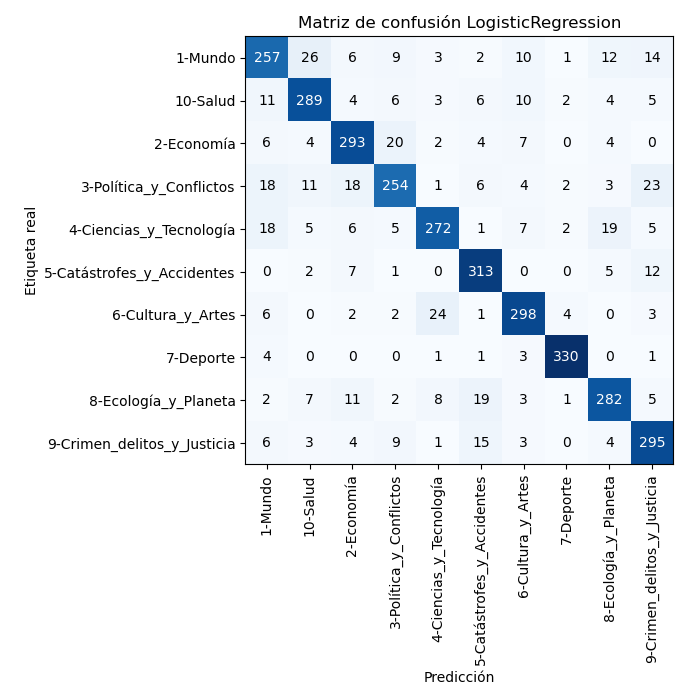

In [34]:
results(ylabels_test_target, lgr, X_test, true_labels)

# rfc anda mejor con spacy_tokenizer

Resultados clasificación
RandomForestClassifier


                             precision    recall  f1-score   support

                    1-Mundo       0.76      0.61      0.68       340
                   10-Salud       0.78      0.78      0.78       340
                 2-Economía       0.82      0.82      0.82       340
    3-Política_y_Conflictos       0.76      0.78      0.77       340
    4-Ciencias_y_Tecnología       0.88      0.76      0.82       340
 5-Catástrofes_y_Accidentes       0.75      0.90      0.82       340
          6-Cultura_y_Artes       0.84      0.88      0.86       340
                  7-Deporte       0.92      0.97      0.95       340
       8-Ecología_y_Planeta       0.83      0.76      0.79       340
9-Crimen_delitos_y_Justicia       0.77      0.85      0.81       340

                   accuracy                           0.81      3400
                  macro avg       0.81      0.81      0.81      3400
               weighted avg       0.81      0.81   

<IPython.core.display.Javascript object>


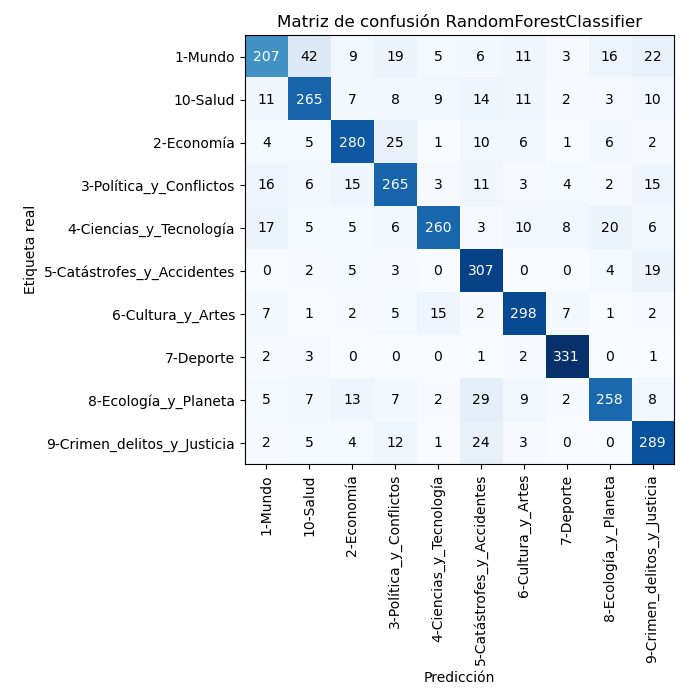

In [35]:
results(ylabels_test_target, rfc, X_test, true_labels)

# cnn

In [7]:

new_df

,id,title,content,category
0,6633017,Disneyland abre sus puertas como centro vacunatorio masivo contra el coronavirus,"Disneyland abre sus puertas como centro vacunatorio masivo contra el coronavirus. El parque de atracciones Disneyland en Anaheim, California, ha estado cerrado desde mediado de marzo por el alza d...",1-Mundo
1,14793496,México autoriza vacuna de Pfizer y es el primer país de Latinoamérica en aprobarla: Inoculación comenzaría este mes,México autoriza vacuna de Pfizer y es el primer país de Latinoamérica en aprobarla: Inoculación comenzaría este mes. La Comisión Federal para la Protección contra Riesgos Sanitarios (Cofepris) del...,1-Mundo
2,14786791,El mega operativo de seguridad en Washington por la investidura de Biden: Será la ceremonia con más militares de la historia,"El mega operativo de seguridad en Washington por la investidura de Biden: Será la ceremonia con más militares de la historia. En Washington, un amplio perímetro que ocupa todo el centro, incluid...",1-Mundo
3,621359,"""Swing states"" o estados bisagras: los terrenos claves donde se definirá la presidencial de EEUU","""Swing states"" o estados bisagras: los terrenos claves donde se definirá la presidencial de EEUU. Estados Unidos está ad portas de elegir a quien dirigirá los destinos del país por los próximos cu...",1-Mundo
4,14797573,"Merkel defiende nuevas restricciones y advierte sobre ""mentiras"" en lucha contra el covid","Merkel defiende nuevas restricciones y advierte sobre ""mentiras"" en lucha contra el covid. La Canciller alemana Angela Merkel defendió este jueves las nuevas medidas restrictivas anunciadas por ...",1-Mundo
...,...,...,...,...
10425,175524,Intendenta de Coquimbo rechaza posible fraude en Papaya Gate: No existe ninguna irregularidad,Intendenta de Coquimbo rechaza posible fraude en Papaya Gate: No existe ninguna irregularidad. Durante este jueves la Unidad de Investigación de Radio Bío Bío dio a conocer un proceso de compra de...,9-Crimen_delitos_y_Justicia
10426,24309,Vecinos de Maipú anuncian manifestaciones tras doble homicidio en feria navideña,"Vecinos de Maipú anuncian manifestaciones tras doble homicidio en feria navideña. A balazos y desde un auto en movimiento, fueron asesinados dos hombres en medio de un feria navideña repleta de ge...",9-Crimen_delitos_y_Justicia
10427,60339,"Matthei y polémicos dichos por defensores públicos: ""Se han convertido en enemigos de la ciudadanía""","Matthei y polémicos dichos por defensores públicos: ""Se han convertido en enemigos de la ciudadanía"". La alcaldesa de Providencia, Evelyn Matthei, se refirió en duros términos a la labor de los de...",9-Crimen_delitos_y_Justicia
10428,13408771,Avanza al Senado el proyecto de ley que otorga reserva de identidad a denunciantes de corrupción,"Avanza al Senado el proyecto de ley que otorga reserva de identidad a denunciantes de corrupción. Este martes, la Cámara de Diputadas y Diputados despachó al Senado el proyecto de ley del Minist...",9-Crimen_delitos_y_Justicia


In [8]:
from sklearn.utils import shuffle
new_df = shuffle(new_df)

In [9]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_index, test_valid_index in split.split(new_df, new_df.category):
    train = new_df.iloc[train_index]
    test_valid_set = new_df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.category):
    test = test_valid_set.iloc[test_index]
    valid = test_valid_set.iloc[valid_index]



#valid, test, train = np.split(new_df, [ int(.15*len(new_df)), int(.3*len(new_df))] )

In [10]:
print(new_df.shape)
print(train.shape)
print(valid.shape)
print(test.shape)

(10430, 4)
(7301, 4)
(1565, 4)
(1564, 4)


In [11]:
display(train.groupby(['category']).size())
display(valid.groupby(['category']).size())
display(test.groupby(['category']).size())

category
1-Mundo                        730
10-Salud                       730
2-Economía                     730
3-Política_y_Conflictos        730
4-Ciencias_y_Tecnología        730
5-Catástrofes_y_Accidentes     730
6-Cultura_y_Artes              730
7-Deporte                      730
8-Ecología_y_Planeta           731
9-Crimen_delitos_y_Justicia    730
dtype: int64

category
1-Mundo                        156
10-Salud                       156
2-Economía                     157
3-Política_y_Conflictos        157
4-Ciencias_y_Tecnología        157
5-Catástrofes_y_Accidentes     156
6-Cultura_y_Artes              157
7-Deporte                      156
8-Ecología_y_Planeta           156
9-Crimen_delitos_y_Justicia    157
dtype: int64

category
1-Mundo                        157
10-Salud                       157
2-Economía                     156
3-Política_y_Conflictos        156
4-Ciencias_y_Tecnología        156
5-Catástrofes_y_Accidentes     157
6-Cultura_y_Artes              156
7-Deporte                      157
8-Ecología_y_Planeta           156
9-Crimen_delitos_y_Justicia    156
dtype: int64

In [12]:
test.category.unique()

array(['2-Economía', '8-Ecología_y_Planeta', '6-Cultura_y_Artes',
       '9-Crimen_delitos_y_Justicia', '7-Deporte',
       '3-Política_y_Conflictos', '10-Salud', '1-Mundo',
       '4-Ciencias_y_Tecnología', '5-Catástrofes_y_Accidentes'],
      dtype=object)

In [16]:
train.to_csv("CNN_train.csv", encoding="UTF-8",index=False)
valid.to_csv("CNN_valid.csv", encoding="UTF-8",index=False)
test.to_csv("CNN_test.csv", encoding="UTF-8",index=False)

In [17]:
import torch
import random
import torchtext
from torchtext import data
from torchtext.legacy import data
from my_funcs import tokenize_es_a

In [18]:
TEXT = data.Field(tokenize=tokenize_es_a, batch_first = True)
CATEGORY = data.LabelField()  # MULTICLASS -se borró el argumento "(dtype = torch.float)"

In [19]:
fields = [(None, None),(None, None),('content', TEXT),('category', CATEGORY)]

In [20]:
%%time
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '.',
                                        train = 'CNN_train.csv',
                                        validation= 'CNN_valid.csv',
                                        test = 'CNN_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)


CPU times: user 11.9 s, sys: 126 ms, total: 12.1 s
Wall time: 12.1 s


In [21]:
BATCH_SIZE = 64
#device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
                                                    (train_data, valid_data, test_data), 
                                                    batch_size = BATCH_SIZE, 
                                                    device = device,
                                                    sort_key=lambda x:len(x.category),
                                                    sort_within_batch=False)

cuda


In [22]:
#!wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

In [23]:
MAX_VOCAB_SIZE = 50000

## TENER VECTORES EN ESPAÑOL
vec = torchtext.vocab.Vectors('glove-sbwc.i25.vec.gz', cache='.')
TEXT.build_vocab(train_data,
                 vectors=vec,
                 max_size=MAX_VOCAB_SIZE,
                 unk_init=torch.Tensor.normal_)


In [24]:
CATEGORY.build_vocab(train_data)

In [25]:
cat_map = { v: k for k, v in CATEGORY.vocab.stoi.items()}
cat_map

{0: '8-Ecología_y_Planeta',
 1: '1-Mundo',
 2: '10-Salud',
 3: '2-Economía',
 4: '3-Política_y_Conflictos',
 5: '4-Ciencias_y_Tecnología',
 6: '5-Catástrofes_y_Accidentes',
 7: '6-Cultura_y_Artes',
 8: '7-Deporte',
 9: '9-Crimen_delitos_y_Justicia'}

In [26]:
print(CATEGORY.vocab.stoi)

defaultdict(None, {'8-Ecología_y_Planeta': 0, '1-Mundo': 1, '10-Salud': 2, '2-Economía': 3, '3-Política_y_Conflictos': 4, '4-Ciencias_y_Tecnología': 5, '5-Catástrofes_y_Accidentes': 6, '6-Cultura_y_Artes': 7, '7-Deporte': 8, '9-Crimen_delitos_y_Justicia': 9})


In [27]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        
        return self.fc(cat)

In [28]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = len(CATEGORY.vocab) ##### MULTICLASS ---> la dimensión del output no es 1 (clasificación binaria)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model = model.to(device)

In [29]:
OUTPUT_DIM

10

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,363,910 trainable parameters


In [31]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [32]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss() #MULTICLASS ---> en lugar de .BCEWithLogitsLoss() (Binary Cross Entropy)


criterion = criterion.to(device)

In [33]:
from tqdm import tqdm
def train(model, iterator, optimizer, criterion, divisor):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in tqdm(iterator, desc='train'):
        
        optimizer.zero_grad()
        
        #print("Tamaño texto de entrada:"+str(batch.body.shape))
        
        predictions = model(batch.content)
        
        #print("Tamaño predecciones de salida:"+str(predictions.shape)) 
        
        #print("Tamaño target:"+str(batch.category.shape)) 
        
        loss = criterion(predictions, batch.category)
        
        acc = categorical_accuracy(predictions, batch.category, divisor)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
def categorical_accuracy(preds, y, divisor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / divisor([y.shape[0]])

In [36]:
def evaluate(model, iterator, criterion, divisor):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in tqdm(iterator, desc='eval'):

            predictions = model(batch.content)
            
            loss = criterion(predictions, batch.category)
            
            acc = categorical_accuracy(predictions, batch.category, divisor)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [37]:
from datetime import datetime
from os import remove
print("inicio optimización")

N_EPOCHS = 10 #5

best_valid_loss = float('inf')
m_info = f'len={MAX_LEN}'
last_best = None
OVERWRITE_MODEL_FILE = True
divisor = torch.FloatTensor if str(device) == 'cpu' else torch.cuda.FloatTensor
for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, divisor)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, divisor)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        dt = str(datetime.now()).replace(' ', '_')
        name = f'./CNN_ep{str(epoch+1)}_{m_info}_{dt}.pt'
        torch.save({'epoca': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'Valid_loss': best_valid_loss}, name)
        if OVERWRITE_MODEL_FILE and last_best is not None:
            remove(last_best)
            last_best = name
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


inicio optimización


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.15it/s]


Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 1.428 | Train Acc: 53.96%
	 Val. Loss: 0.721 |  Val. Acc: 79.03%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.41it/s]


Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.680 | Train Acc: 78.40%
	 Val. Loss: 0.569 |  Val. Acc: 82.16%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.36it/s]


Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 0.479 | Train Acc: 84.93%
	 Val. Loss: 0.521 |  Val. Acc: 84.07%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.40it/s]


Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.355 | Train Acc: 89.05%
	 Val. Loss: 0.489 |  Val. Acc: 84.75%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.31it/s]


Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.246 | Train Acc: 92.80%
	 Val. Loss: 0.523 |  Val. Acc: 83.52%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 21.95it/s]


Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.170 | Train Acc: 95.23%
	 Val. Loss: 0.514 |  Val. Acc: 84.32%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.18it/s]


Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 0.115 | Train Acc: 96.78%
	 Val. Loss: 0.523 |  Val. Acc: 84.25%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.57it/s]


Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.074 | Train Acc: 98.40%
	 Val. Loss: 0.516 |  Val. Acc: 85.19%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.55it/s]


Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 0.048 | Train Acc: 99.21%
	 Val. Loss: 0.517 |  Val. Acc: 85.19%


eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 22.00it/s]

Epoch: 10 | Epoch Time: 0m 33s
	Train Loss: 0.038 | Train Acc: 99.32%
	 Val. Loss: 0.542 |  Val. Acc: 85.19%


In [38]:
name

'./CNN_ep4_len=1600_2021-12-14_22:33:38.096576.pt'

In [39]:
best_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [40]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

best_model.embedding.weight.data.copy_(pretrained_embeddings)
best_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
best_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [41]:
m_name = name

In [42]:
best_model.load_state_dict(torch.load(m_name, map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [43]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, divisor)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

eval: 100%|█████████████████████████████████████| 25/25 [00:01<00:00, 21.81it/s]

Test Loss: 0.551 | Test Acc: 84.50%


In [44]:
best_model.eval()
prediction_test = []
labels_test=[]
for batch in test_iterator:
    labels_test.append(batch.category.cpu().detach().numpy())
    predictions = best_model(batch.content.cpu()).squeeze(1)
    prediction_test.append(predictions.argmax(dim=1).detach().numpy())
    #print(torch.sigmoid(predictions))
    #rounded_preds = torch.round(torch.sigmoid(predictions))
    #prediction_test.append(rounded_preds.detach().numpy())
    #print(prediction_test)
    
y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)

In [45]:
lbs = list(cat_map.values())
lbs

['8-Ecología_y_Planeta',
 '1-Mundo',
 '10-Salud',
 '2-Economía',
 '3-Política_y_Conflictos',
 '4-Ciencias_y_Tecnología',
 '5-Catástrofes_y_Accidentes',
 '6-Cultura_y_Artes',
 '7-Deporte',
 '9-Crimen_delitos_y_Justicia']

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
print(classification_report(y_true,
                            y_pred,
                            target_names=lbs,))

                             precision    recall  f1-score   support

       8-Ecología_y_Planeta       0.82      0.83      0.82       156
                    1-Mundo       0.77      0.80      0.79       157
                   10-Salud       0.84      0.81      0.82       157
                 2-Economía       0.83      0.88      0.85       156
    3-Política_y_Conflictos       0.83      0.80      0.82       156
    4-Ciencias_y_Tecnología       0.87      0.81      0.84       156
 5-Catástrofes_y_Accidentes       0.91      0.82      0.86       157
          6-Cultura_y_Artes       0.87      0.93      0.90       156
                  7-Deporte       0.97      0.98      0.98       157
9-Crimen_delitos_y_Justicia       0.76      0.79      0.77       156

                   accuracy                           0.85      1564
                  macro avg       0.85      0.85      0.85      1564
               weighted avg       0.85      0.85      0.85      1564



In [47]:
%matplotlib notebook
def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.yticks(tick_marks, labels)
    plt.xticks(tick_marks, labels, rotation=90)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

<IPython.core.display.Javascript object>


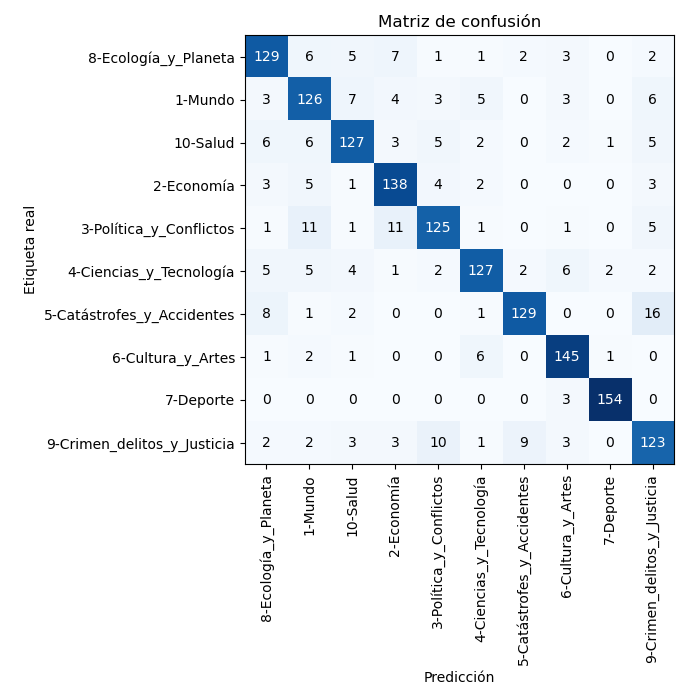

In [48]:
plot_confusion_matrix(cm, labels=lbs)

In [49]:
# best_mode.eval()
#best_model.train(mode=False)

In [50]:
def predict_class(model, sentence, min_len = 4):

    tokenized = [tok.text for tok in spacy_es.tokenizer(sentence)]
    
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    device = 'cpu'
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    preds = model(tensor)
    print(preds)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [51]:
noticia = """Sin embargo, estos experimentos se llevaban a cabo en secreto, y cuando otras secciones de Guardian se dieron cuenta, el proyecto se canceló de inmediato."""
cat_map.get(predict_class(best_model, noticia))

NameError: name 'spacy_es' is not defined

In [ ]:
cat_map.get(predict_class(best_model, "golazo del bicho vs villareal"))